# Getting started

Once you've chosen your scenario, download the data from [the Iowa website](https://data.iowa.gov/Economy/Iowa-Liquor-Sales/m3tr-qhgy) in csv format. Start by loading the data with pandas. You may need to parse the date columns appropriately.

In [111]:
import pandas as pd
import re
#Load the data into a DataFrame
df = pd.read_csv('Iowa_Liquor_sales_sample_10pct.csv')

## Transform the dates if needed, e.g.
df["Date"] = pd.to_datetime(df["Date"], format="%m/%d/%Y")


# df.info()
# Shows me that county and county numberh have nans. zip code is no nans and can find county if we want to.
# Volume in gallons is same as volume in ml, so drop
df.drop('Volume Sold (Gallons)',axis=1,inplace=True)
df.columns = ['date', 'store_number','city','zip_code','county_number','county','category','cat_name','vendor','item_number','item_desc','btl_vol','st_btl_cost','st_btl_retail','btls_sold','sale','vol_sold']
df.drop('category',axis=1,inplace=True)
df.drop('county',axis=1,inplace=True)
df.drop('county_number',axis=1,inplace=True)

# change $ columns to float and no $ or ,
df['st_btl_cost'] = [float(x.replace('$','')) for x in df['st_btl_cost']]
df['st_btl_retail'] = [float(x.replace('$','')) for x in df['st_btl_retail']]
df['sale'] = [float(x.replace('$','')) for x in df['sale']]

df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df.head()

,date,store_number,city,zip_code,cat_name,vendor,item_number,item_desc,btl_vol,st_btl_cost,st_btl_retail,btls_sold,sale,vol_sold,year,month
0,2015-11-04,3717,SUMNER,50674,APRICOT BRANDIES,55,54436,Mr. Boston Apricot Brandy,750,4.50,6.75,12,81.00,9.0,2015,11
1,2016-03-02,2614,DAVENPORT,52807,BLENDED WHISKIES,395,27605,Tin Cup,750,13.75,20.63,2,41.26,1.5,2016,3
2,2016-02-11,2106,CEDAR FALLS,50613,STRAIGHT BOURBON WHISKIES,65,19067,Jim Beam,1000,12.59,18.89,24,453.36,24.0,2016,2
3,2016-02-03,2501,AMES,50010,AMERICAN COCKTAILS,395,59154,1800 Ultimate Margarita,1750,9.50,14.25,6,85.50,10.5,2016,2
4,2015-08-18,3654,BELMOND,50421,VODKA 80 PROOF,297,35918,Five O'clock Vodka,1750,7.20,10.80,12,129.60,21.0,2015,8


# Explore the data

Perform some exploratory statistical analysis and make some plots, such as histograms of transaction totals, bottles sold, etc.

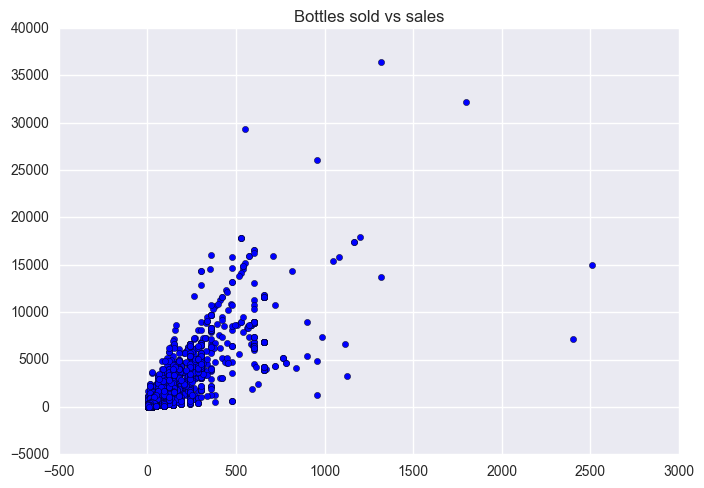

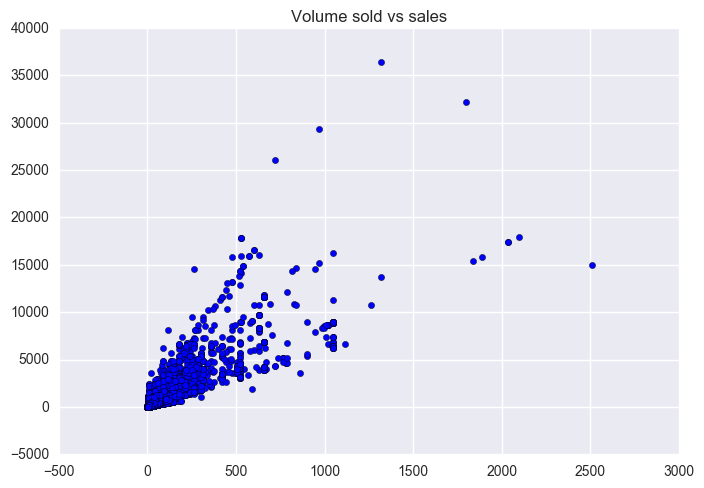

In [160]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

plt.scatter(df['btls_sold'], df['sale'])
plt.title("Bottles sold vs sales")
plt.show()

plt.scatter(df['vol_sold'], df['sale'])
plt.title("Volume sold vs sales")
plt.show()



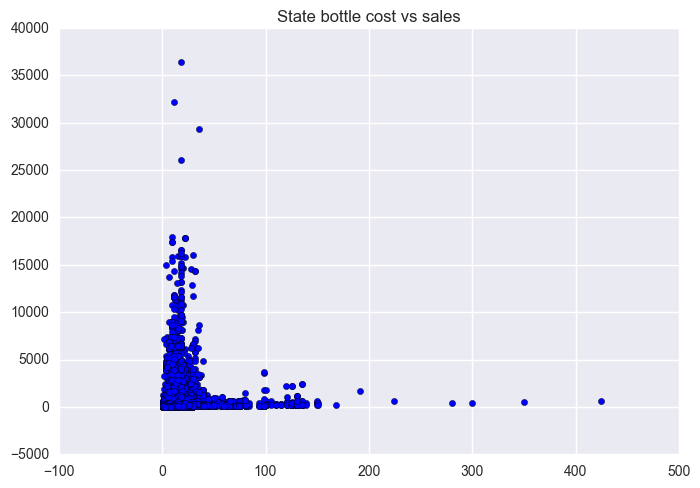

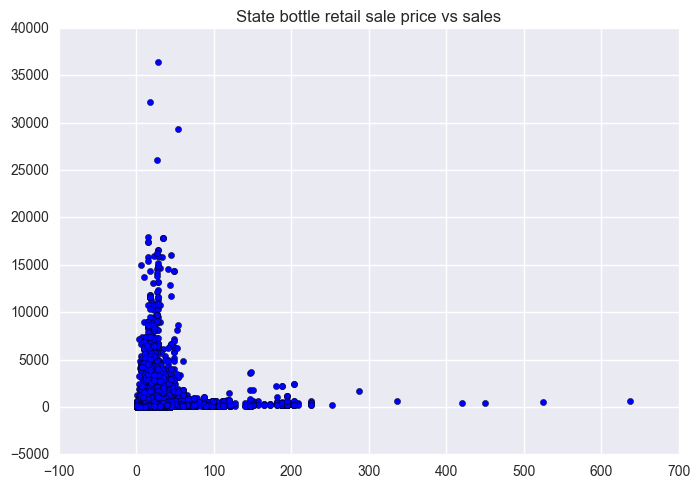

In [161]:
plt.scatter(df['st_btl_cost'], df['sale'])
plt.title("State bottle cost vs sales")
plt.show()

plt.scatter(df['st_btl_retail'], df['sale'])
plt.title("State bottle retail sale price vs sales")
plt.show()

## Record your findings

Be sure to write out anything observations from your exploratory analysis.

# Mine the data
Now you are ready to compute the variables you will use for your regression from the data. For example, you may want to
compute total sales per store from Jan to March of 2015, mean price per bottle, etc. Refer to the readme for more ideas appropriate to your scenario.

Pandas is your friend for this task. Take a look at the operations [here](http://pandas.pydata.org/pandas-docs/stable/groupby.html) for ideas on how to make the best use of pandas and feel free to search for blog and Stack Overflow posts to help you group data by certain variables and compute sums, means, etc. You may find it useful to create a new data frame to house this summary data.

# Refine the data
Look for any statistical relationships, correlations, or other relevant properties of the dataset.

In [149]:
# drop nulls because we don't care about data where a store didn't have a sale in both years
sales_2015 = pd.pivot_table(df[df['year'] == 2015], values=['sale'], index=['store_number'], columns=['year'], aggfunc=sum).dropna()
sales_2015['store_number'] = sales_2015.index

#Q1 2015 dataframe
q1 = df[(df['month'] < 4) & (df['year'] == 2015)]

#features to look at
sums = pd.pivot_table(q1, values=['sale','btls_sold','vol_sold','st_btl_retail','st_btl_cost'], index=['store_number'], columns=['year'], aggfunc=sum).dropna()
sums['margin'] = sums['st_btl_retail'] - sums['st_btl_cost']
sums['store_number'] = sums.index

pivot = sales_2015.merge(sums, how = 'inner', on = 'store_number')

#Q1 2016 dataframe
q1_2016 = df[(df['month'] < 4) & (df['year'] == 2016)]

sums_2016 = pd.pivot_table(q1_2016, values=['sale','btls_sold','vol_sold','st_btl_retail','st_btl_cost'], index=['store_number'], columns=['year'], aggfunc=sum).dropna()
sums_2016['store_number'] = sums_2016.index

#make same size
pivot_2016 = sales_2015.merge(sums_2016, how = 'inner', on = 'store_number')
pivot_2016['margin'] = pivot_2016['st_btl_retail'] - pivot_2016['st_btl_cost']


from sklearn import datasets, linear_model, metrics
from sklearn.cross_validation import cross_val_score, cross_val_predict, train_test_split
from sklearn.metrics import r2_score

#FIND BEST SINGLE AND DOUBLE VALS

def modeler(lst):
    lm = linear_model.LinearRegression()

    X = pivot[lst]
    y = pivot['sale_x']
    model = lm.fit(X, y)

    return model.score(X, y)

#best single var
best = 0
combo = ""
columns = ['sale_y','btls_sold','vol_sold','st_btl_retail','margin']
for x in columns:
    r2 = modeler([x])
    if r2 > best or best == 0:
        best = r2
        combo = x
print "Best one var: "
print "%s: %s" % (best, x)


#best of 2
best = 0
combo = ""
columns = ['sale_y','btls_sold','vol_sold','st_btl_retail','margin']
for x in columns:
    for y in columns:
        if x != y:
            r2 = modeler([x,y])
            if r2 > best or best == 0:
                best = r2
                combo = "%s and %s" % (x,y)  
print "Best two vars: "
print "%s: %s" % (combo, best)

# Added vol_sold for funsies
print "With vol_sold"
print modeler(['sale_y','vol_sold','margin'])

# data displays
# sales_2015.head()
# pivot_2016.head()
# pivot.head()

Best one var: 
0.963255623418: margin
Best two vars: 
sale_y and margin: 0.963965434286
With vol_sold
0.96453516156


# Build your models

Using scikit-learn or statsmodels, build the necessary models for your scenario. Evaluate model fit.

In [150]:
import matplotlib.pyplot as plt

# TRAIN THE MODEL using best variables from Q1 2015
lm = linear_model.LinearRegression()

X = pivot[['sale_y', 'margin','vol_sold']]
y = pivot['sale_x']

#train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# model with x_train, y_train
model = lm.fit(X_train, y_train)

# Perform 6-fold cross validation
scores = cross_val_score(model, X, y, cv=10)
print "Cross-validated scores:", scores

# Cross val predict
predictions = cross_val_predict(model, X, y, cv=10)
accuracy = metrics.r2_score(y, predictions)
print "Cross-Predicted Accuracy:", accuracy


Cross-validated scores: [ 0.96029251  0.92754789  0.91248351  0.93558391  0.77653075  0.88971552
  0.74183103  0.64719244  0.99436465  0.83306701]
Cross-Predicted Accuracy: 0.959995600055


## Plot your results

Again make sure that you record any valuable information. For example, in the tax scenario, did you find the sales from the first three months of the year to be a good predictor of the total sales for the year? Plot the predictions versus the true values and discuss the successes and limitations of your models

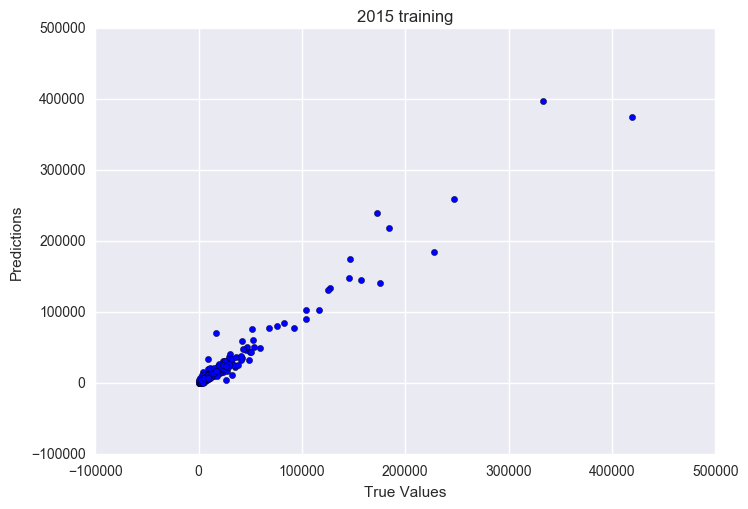

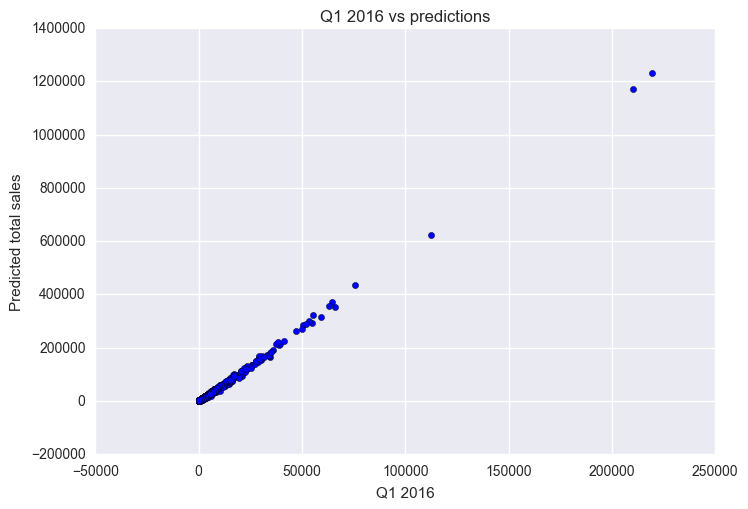

In [151]:
import numpy as py
#predict on 2015. This model does not account for outliers.
predictions = model.predict(X_test)

plt.scatter(y_test, predictions)
plt.title("2015 training")
plt.xlabel("True Values")
plt.ylabel("Predictions")
plt.show()

# predict 2016 total sales using model from 2015 and relevant q1 2016 data
X = pivot_2016[[('sale', 2016), ('vol_sold', 2016), ('margin', "" )]]

predictions = model.predict(X)

#show that the total sales correlate with Q1 2016
plt.scatter(pivot_2016[('sale', 2016)], predictions)
plt.title('Q1 2016 vs predictions')
plt.xlabel("Q1 2016")
plt.ylabel("Predicted total sales")
plt.show()

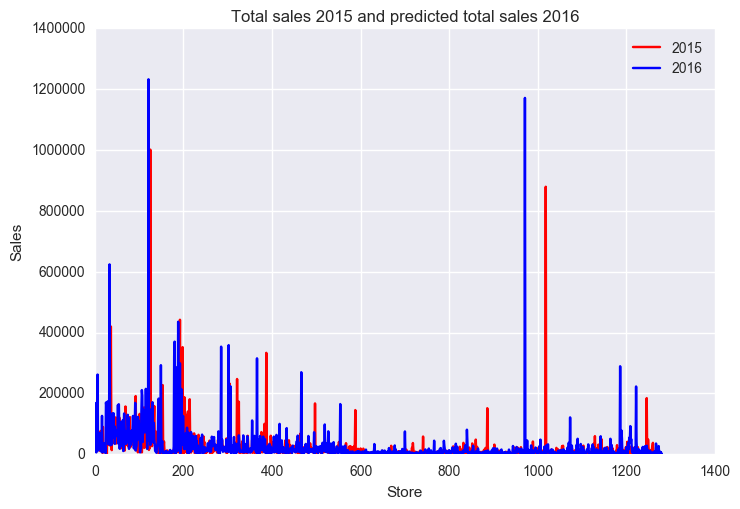

In [159]:
# Predictions are about the same size as 2015 total sales so it is reasonable..
plt.plot(pivot['sale_x'], color = 'r', label = '2015')
plt.plot(predictions, color = 'b', label = '2016')
plt.xlabel('Store')
plt.ylabel('Sales')
plt.legend()
plt.title("Total sales 2015 and predicted total sales 2016")
plt.show()

# Present the Results

Present your conclusions and results. If you have more than one interesting model feel free to include more than one along with a discussion. Use your work in this notebook to prepare your write-up.

In [145]:
print "2016 predicted total sales: "
print int(sum(predictions))

print '2015 total sales'
print int(sum(sales_2015['sale', 2015]))

print "Projected increase"
print int(sum(predictions)) - int(sum(sales_2015['sale', 2015]))

2016 predicted total sales: 
32478165
2015 total sales
28527245
Projected increase
3950920


In [162]:
#https://royaltydatascience.wordpress.com/2016/10/25/linear-regression-market-research/